### Load dataset

In [1]:
from utils import CustomDataModule

d_modul = CustomDataModule()
d_modul.setup("train")

### Data distribution

In [2]:
from collections import Counter

train_loader = d_modul.train_dataloader()
val_loader = d_modul.val_dataloader()
test_loader = d_modul.test_dataloader()

train_counter = Counter()
for images, labels in train_loader:
    train_counter.update(labels.tolist())

print(f"\nTraining label distribution:\n{sorted(train_counter.items())}")


val_counter = Counter()
for images, labels in val_loader:
    val_counter.update(labels.tolist())

print(f"\nValidation label distribution:\n{sorted(val_counter.items())}")


test_counter = Counter()
for images, labels in test_loader:
    test_counter.update(labels.tolist())

print(f"\nTest label distribution:\n{sorted(test_counter.items())}")


Training label distribution:
[(0, 7209), (1, 7191)]

Validation label distribution:
[(0, 791), (1, 809)]

Test label distribution:
[(0, 2027), (1, 1973)]


### Majority class classifier

In [3]:
majority_class = test_counter.most_common(1)[0]
print(f"Majority class {majority_class[0]}")

baseline_acc = majority_class[1] / sum(test_counter.values())
print(f"Accuracy when always predicting majority class {baseline_acc:.2f} {baseline_acc * 100:.2f}%")

Majority class 0
Accuracy when always predicting majority class 0.51 50.68%


### Model Checkpointing

In [4]:
import lightning as L
import torch
from lightning.pytorch.loggers import CSVLogger

In [5]:
class PyTorchMLP(torch.nn.Module):
    def __init__(self, num_features, num_classes):
        super().__init__()

        self.all_layers = torch.nn.Sequential(
            # 1st hidden layer
            torch.nn.Linear(num_features, 100),
            torch.nn.ReLU(),
            # 2nd hidden layer
            torch.nn.Linear(100, 50),
            torch.nn.ReLU(),
            # output layer
            torch.nn.Linear(50, num_classes),
        )

    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        logits = self.all_layers(x)
        return logits

In [6]:
torch.manual_seed(42)

pt_model = PyTorchMLP(num_features=100, num_classes=2)

In [7]:
from lightning.pytorch.callbacks import ModelCheckpoint

callbacks = [
    ModelCheckpoint(save_top_k=1, mode="max", monitor="val_acc", save_last=True)
]

In [8]:
from utils import LightningModel

lt_model = LightningModel(model=pt_model, learning_rate=0.05)

trainer = L.Trainer(
    callbacks=callbacks,
    max_epochs=10,
    accelerator="gpu",
    devices="auto",
    logger=CSVLogger(save_dir="csv_logs", name="lt_model"),
    deterministic=True
)

trainer.fit(lt_model, datamodule=d_modul)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3060') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type               | Params
-------------------------------------------------
0 | model     | PyTorchMLP         | 15.3 K
1 | train_acc | MulticlassAccuracy | 0     
2 | val_acc   | MulticlassAccuracy | 0     
3 | test_acc  | MulticlassAccuracy | 0     
-------------------------------------------------
15.3 K    Trainable params
0         Non-trainable params
15.3 K    Total params
0.061     Total estimated model params s

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

D:\Programming Train\dl_lightning_ai_course\venv\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
D:\Programming Train\dl_lightning_ai_course\venv\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


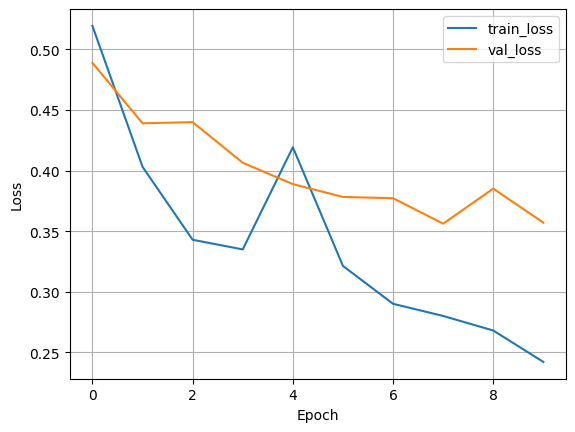

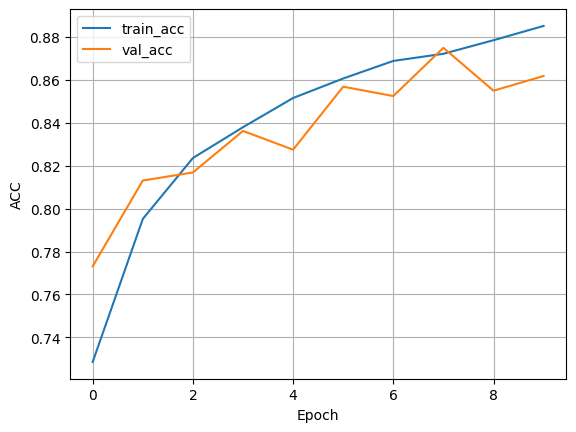

In [9]:
from utils import plot_csv_logger

plot_csv_logger(csv_path=f"{trainer.logger.log_dir}/metrics.csv")

### Best Checkpoint

In [10]:
trainer.test(model=lt_model, datamodule=d_modul, ckpt_path="best")

Restoring states from the checkpoint path at csv_logs\lt_model\version_3\checkpoints\epoch=7-step=3600.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at csv_logs\lt_model\version_3\checkpoints\epoch=7-step=3600.ckpt
D:\Programming Train\dl_lightning_ai_course\venv\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.8687499761581421
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_acc': 0.8687499761581421}]

In [11]:
trainer.test(model=lt_model, datamodule=d_modul, ckpt_path="last")

D:\Programming Train\dl_lightning_ai_course\venv\lib\site-packages\lightning\pytorch\trainer\connectors\checkpoint_connector.py:186: .test(ckpt_path="last") is set, but there is no last checkpoint available. No checkpoint will be loaded.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.8687499761581421
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_acc': 0.8687499761581421}]

In [13]:
path = trainer.checkpoint_callback.best_model_path
print(path)

csv_logs\lt_model\version_3\checkpoints\epoch=7-step=3600.ckpt


In [14]:
lightning_model = LightningModel.load_from_checkpoint(path, learning_rate=0.1, model=pt_model)
lightning_model.eval()

LightningModel(
  (model): PyTorchMLP(
    (all_layers): Sequential(
      (0): Linear(in_features=100, out_features=100, bias=True)
      (1): ReLU()
      (2): Linear(in_features=100, out_features=50, bias=True)
      (3): ReLU()
      (4): Linear(in_features=50, out_features=2, bias=True)
    )
  )
  (train_acc): MulticlassAccuracy()
  (val_acc): MulticlassAccuracy()
  (test_acc): MulticlassAccuracy()
)

In [15]:
trainer.test(model=lightning_model, datamodule=d_modul)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
D:\Programming Train\dl_lightning_ai_course\venv\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.8687499761581421
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_acc': 0.8687499761581421}]